In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode'
pio.templates.default = 'plotly'

Downloading data and unzipping it:

In [3]:
!kaggle competitions download -c predict-electricity-consumption
!tar -xf predict-electricity-consumption.zip
!mkdir data
!move train.csv data
!move test.csv data
!move sample_submission.csv data
!del predict-electricity-consumption.zip


  0%|          | 0.00/174k [00:00<?, ?B/s]
100%|██████████| 174k/174k [00:00<00:00, 942kB/s]
100%|██████████| 174k/174k [00:00<00:00, 937kB/s]
A subdirectory or file data already exists.


        1 file(s) moved.
        1 file(s) moved.
        1 file(s) moved.


In [3]:
train = pd.read_csv('data/train.csv')

In [4]:
train.head()

time  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0  2021-09-01 00:00:00+03:00  11.2  10.3  94.0   NaN   NaN  320.0   7.2  16.7   
1  2021-09-01 01:00:00+03:00  10.7   9.6  93.0   NaN   NaN  320.0   7.2  13.0   
2  2021-09-01 02:00:00+03:00   9.9   9.0  94.0   NaN   NaN  320.0   7.2  13.0   
3  2021-09-01 03:00:00+03:00  10.0   8.4  90.0   NaN   NaN  330.0   7.2  13.0   
4  2021-09-01 04:00:00+03:00   9.0   8.1  94.0   NaN   NaN  300.0   3.6  13.0   

     pres  coco  el_price  consumption  
0  1012.6   2.0   0.09016        0.577  
1  1012.6   2.0   0.09251        0.594  
2  1012.2   2.0   0.08890        0.685  
3  1011.9   1.0   0.08735        1.016  
4  1011.4   2.0   0.08688        0.677

In [5]:
train.shape

(8592, 13)

In [6]:
train.dtypes

time            object
temp           float64
dwpt           float64
rhum           float64
prcp           float64
snow           float64
wdir           float64
wspd           float64
wpgt           float64
pres           float64
coco           float64
el_price       float64
consumption    float64
dtype: object

In [7]:
# Count missing values
train.isna().sum()

time              0
temp              0
dwpt              0
rhum              0
prcp           6433
snow           8473
wdir              0
wspd              0
wpgt              0
pres              0
coco            196
el_price          0
consumption       2
dtype: int64

In [8]:
train['time'] = pd.to_datetime(train['time'], utc=True).dt.tz_convert('Europe/Tallinn')

In [9]:
train.set_index('time', drop=True, inplace=True)

In [10]:
# Show rows with missing consumption
missing_consumption = train.loc[train['consumption'].isnull()]
missing_consumption

temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
time                                                                         
2021-10-31 03:00:00+02:00   7.1   5.2  88.0   NaN   NaN  180.0  10.8  18.5   
2022-03-27 04:00:00+03:00  -2.7 -10.5  55.0   NaN   NaN  330.0  14.4  38.9   

                             pres  coco  el_price  consumption  
time                                                            
2021-10-31 03:00:00+02:00  1015.2   1.0   0.06003          NaN  
2022-03-27 04:00:00+03:00  1020.6   2.0   0.10007          NaN

In [11]:
# Show iloc of missing consumption
missing_consumption_iloc = [train.index.get_loc(missing_consumption.iloc[row].name) for row in range(missing_consumption.shape[0])]
missing_consumption_iloc

[1444, 4972]

In [12]:
# Temporary fix for missing consumption
for iloc in missing_consumption_iloc:
  train['consumption'].iloc[iloc] = train['consumption'].iloc[iloc-15:iloc+15].mean()

In [13]:
fig = px.line(train, x=train.index, y=train.columns)
fig.show()

In [63]:
train_days = 14 * 24
test_days = 7 * 24
train_fold = train.iloc[train.shape[0]-(test_days+train_days):train.shape[0]-test_days]
test_fold = train.iloc[train.shape[0]-test_days:]

In [15]:
print(f'{train_fold.shape=}, {test_fold.shape=}')

train_fold.shape=(720, 12), test_fold.shape=(168, 12)


In [16]:
# ADF test
from statsmodels.tsa.stattools import adfuller

def adfuller_test(target):
    result = adfuller(target)
    labels = ['ADF test statistics', 'P-value', '# Lags used', 'Number of observation used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis (Ho), Reject the null hypothesis, Data has no unit root and is stationary')
    else:
        print('Weak evidence against the null hypothesis (Ho), time series has a unit root, indicating it is non stationary. ')

In [17]:
adfuller_test(train_fold['consumption'])

ADF test statistics : -10.386214640019142
P-value : 2.076796861317148e-18
# Lags used : 14
Number of observation used : 705
Strong evidence against the null hypothesis (Ho), Reject the null hypothesis, Data has no unit root and is stationary


In [27]:
from statsmodels.tsa.stattools import pacf, acf 

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(figsize=(16,9), dpi= 1000)
plot_pacf(train_fold.consumption, lags=72, ax=axes)
plt.show()

c:\Users\Ivan\anaconda3\envs\UT_ML\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



In [52]:
print(f'Max PACF: {pacf(train_fold.consumption)[1:].max()}, lag: {pacf(train_fold.consumption)[1:].argmax()}')

Max PACF: 0.20695170664007304, lag: 23


In [25]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(figsize=(16,9), dpi= 1000)
plot_acf(train_fold.consumption, lags=72, ax=axes)
plt.show()

In [53]:
print(f'Max ACF: {acf(train_fold.consumption)[1:].max()}, lag: {acf(train_fold.consumption)[1:].argmax()}')

Max ACF: 0.2728694892302508, lag: 23


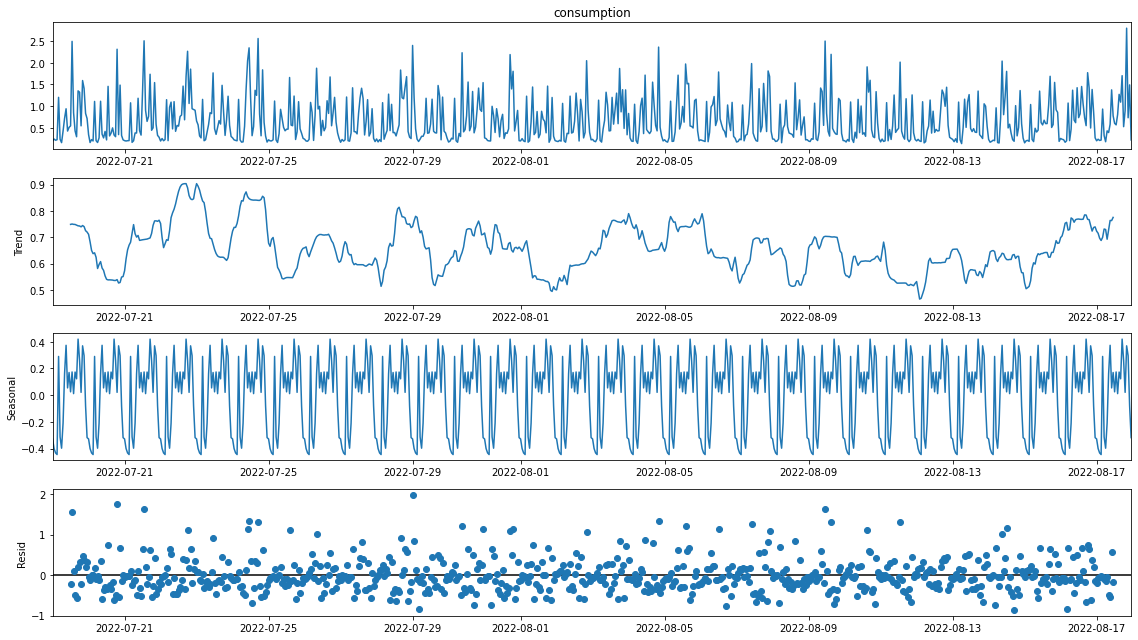

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition = seasonal_decompose(train_fold['consumption'], model='additive')

fig = additive_decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [26]:
fig, axes = plt.subplots(figsize=(16,9), dpi= 1000)
plot_pacf(additive_decomposition.seasonal, lags=72, ax=axes)
plt.show()

In [45]:
seasonal_acf = acf(additive_decomposition.seasonal, nlags=72)
print(f'Max ACF: {seasonal_acf[1:].max()}, lag: {seasonal_acf[1:].argmax()}')

Max ACF: 0.9666666666666665, lag: 23


In [50]:
seasonal_pacf = pacf(additive_decomposition.seasonal, nlags=72)
print(f'Max PACF: {seasonal_pacf[1:].min()}, lag: {seasonal_pacf[1:].argmin()}')

Max PACF: -8.334927496158937, lag: 62


In [35]:
from statsmodels.tsa.arima.model import ARIMA

In [60]:
import pmdarima as pm

In [82]:
model = pm.auto_arima(train_fold['consumption'],
                      X=train_fold[['temp']], 
                      m=24,
                      trace=True,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=455.141, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=444.516, Time=0.98 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=448.257, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=453.263, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=455.267, Time=0.23 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=430.716, Time=4.66 sec


In [73]:
model = ARIMA(train_fold[['consumption']], exog=train_fold[['temp']], order=(0, 0, 0), seasonal_order=(2, 0, 0, 24), enforce_stationarity=False, freq=train_fold.index.inferred_freq)

c:\Users\Ivan\anaconda3\envs\UT_ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [74]:
model_fit = model.fit()

In [75]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            consumption   No. Observations:                  336
Model:             ARIMA(2, 0, 0, 24)   Log Likelihood                -175.576
Date:                Thu, 10 Nov 2022   AIC                            361.152
Time:                        22:29:11   BIC                            379.467
Sample:                    08-04-2022   HQIC                           368.491
                         - 08-17-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1333      0.186      0.717      0.474      -0.231       0.498
temp           0.0256      0.008      3.165      0.002       0.010       0.041
ar.S.L24       0.1479      0.062      2.378      0.017       0.026       0.270
ar.S.L48       0.2414      0.051      4.691      0.000       0.141       0.342
sigma2         0.1982      0.016     12.216      0.000       0.166       0.230
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):               157.63
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             1.37
Prob(H) (two-sided):                  0.59   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
predictions = model_fit.predict(start=test_fold.index[0], end=test_fold.index[-1], exog=test_fold[['temp']], axis=1)

In [79]:
# residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

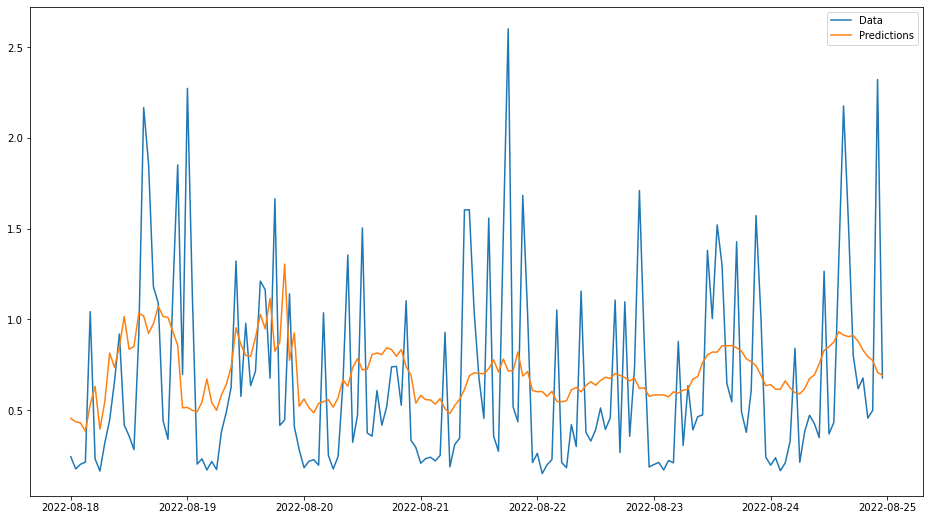

In [80]:
plt.figure(figsize=(16,9))
plt.plot(test_fold['consumption'])
plt.plot(predictions)
plt.legend(('Data', 'Predictions'))
plt.show

In [72]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_fold['consumption'], predictions)

0.3964005912733424